In [66]:
import pandas as pd 
import numpy as np 
from glob import glob
from scipy.signal import find_peaks_cwt
import matplotlib.pyplot as plt 

%matplotlib inline

In [54]:
def get_hwfm(spec, num_sds=5):
    # spec: 2D spectrum image
    spec_mean = spec.sum(1)
    plt.plot(spec_mean)
    peak_idx = find_peaks_cwt(spec_mean, range(1, 20))
    if len(peak_idx) < num_sds:
        raise Exception("cannot find peaks match expected number of sds!")
    peak_idx = peak_idx[-num_sds:] # 只取最後5個peak

    # 確認抓到的peak是正確的
    for i, pp in enumerate(peak_idx):
        plt.scatter(pp, spec_mean[pp])
        plt.text(x=pp, y=spec_mean[pp], s=str(i+1))
        
    def fwhm(peak, signal):
        m = signal[peak]
        l = r = peak
        while signal[l] > m/2 and l > 0:
            l -= 1
        while signal[r] > m/2 and r < len(signal)-1:
            r += 1

        return l, r   
    
    phantom = []
    for i, pp in enumerate(peak_idx):
        l, r = fwhm(pp, spec_mean - spec_mean.min())
        plt.plot([l, l], [0, spec_mean[l]], color="C{}".format(i))
        plt.plot([r, r], [0, spec_mean[r]], color="C{}".format(i))
        
        phantom += [spec[l:r].mean(0)]
    phantom = np.asarray(phantom)
    plt.show()
    
    return phantom


In [ ]:
def check_hwfm(d):
    plt.plot(d.sum(1))
    p = find_peaks_cwt(d.sum(1), range(1, 20))
    for i, pp in enumerate(p[-5:]):
        plt.scatter(pp, d.sum(1)[pp])
        plt.text(x=pp, y=d.sum(1)[pp], s=str(i+1))

    def fwhm(peak, signal):
        m = signal[peak]
        l = r = peak
        while signal[l] > m/2 and l > 0:
            l -= 1
        while signal[r] > m/2 and r < len(signal)-1:
            r += 1

        return l, r

    for i, pp in enumerate(p[-5:]):
        print(pp)
        l, r = fwhm(pp, d.sum(1)-d.sum(1).min())
        print(l, r)
        plt.plot([l, l], [0, d.sum(1)[l]], color="C{}".format(i))
        plt.plot([r, r], [0, d.sum(1)[r]], color="C{}".format(i))
    plt.show()

In [ ]:
path = "data/raw/20190502/muscle/background_*.txt"
p_list = glob(path)

bg = []
for p in p_list:
    bg += [np.loadtxt(p)]
bg = np.asarray(bg)
print(bg.shape)
bg = bg.mean(0)
plt.imshow(bg)

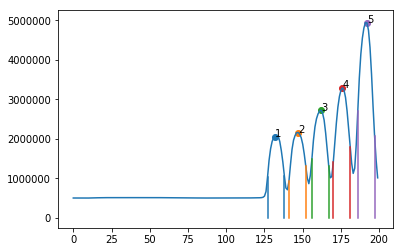

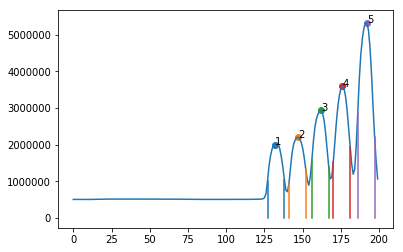

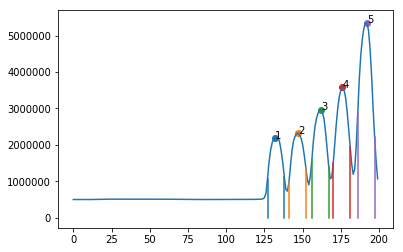

In [107]:
live_list = glob("data/raw/20190502/muscle/live/*")
live_list.sort(key=lambda x: (x.split("live_")[-1].split('_')[0], x.split("live_")[-1].split('_')[1]))
if len(live_list) % 5 != 0:
    raise Exception("live folder seems conatain other files")

live = []
for i in range(int(len(live_list)/5)):
    live_ = []
    for l in live_list[i*5:(i+1)*5]:
        live_ += [np.loadtxt(l)]
    live_ = np.asarray(live_).mean(0)
    live_ = get_hwfm(live_)
    live += [live_]
    
    
live = np.asarray(live)



In [108]:
live.shape

(3, 5, 1600)

In [89]:
p_id = "chik"

phantom = []
for pp in p_id:
    path = "data/raw/20190502/muscle/phantom/phantom_{}_X*.txt".format(pp)
    p_list = glob(path)
    phantom_ = []
    for p in p_list:
        phantom_ += [np.loadtxt(p)]
        
    phantom_ = np.asarray(phantom_).mean(0)
    phantom_ = get_hwfm(phantom_)
    phantom += [phantom_]
    
phantom = np.asarray(phantom)

phantom.shape

/Users/tushicheng/toast_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/Users/tushicheng/toast_env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AxisError: axis 1 is out of bounds for array of dimension 0

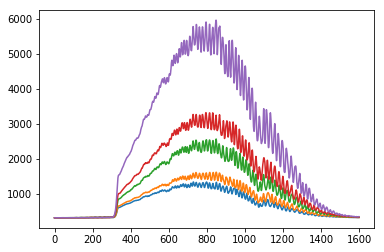

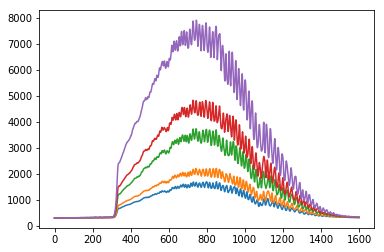

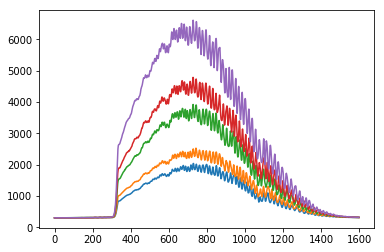

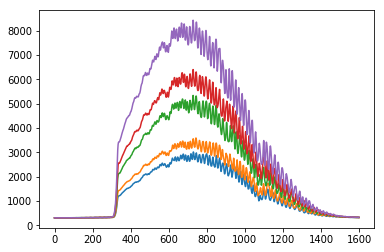

In [56]:
for p in phantom:
    for pp in p:
        plt.plot(pp)
    plt.show()

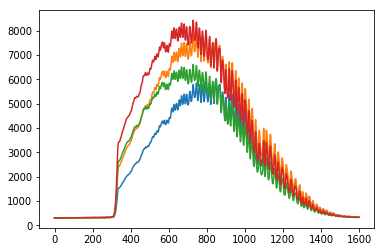

In [64]:
for p in phantom[:,4,:]:
    plt.plot(p)
plt.show()

In [59]:
phantom.shape

(4, 5, 1600)

In [75]:
wl_calib = np.loadtxt("data/raw/20190502/muscle/calib_wl.csv", delimiter=",")
len(wl_calib)

1600

In [88]:
wl = [i for i in range(660, 920, 10)]
phantom_interp = []
for p in phantom:
    phantom_ = []
    for pp in p:
        phantom_ += [np.interp(wl, wl_calib, pp)]
    phantom_interp += [np.asarray(phantom_)]
phantom_interp = np.asarray(phantom_interp)
phantom_interp.shape

(4, 5, 26)